In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
40956,NaN,NaN,International,2020-08-30,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40957,NaN,NaN,International,2020-08-31,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40958,NaN,NaN,International,2020-09-01,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


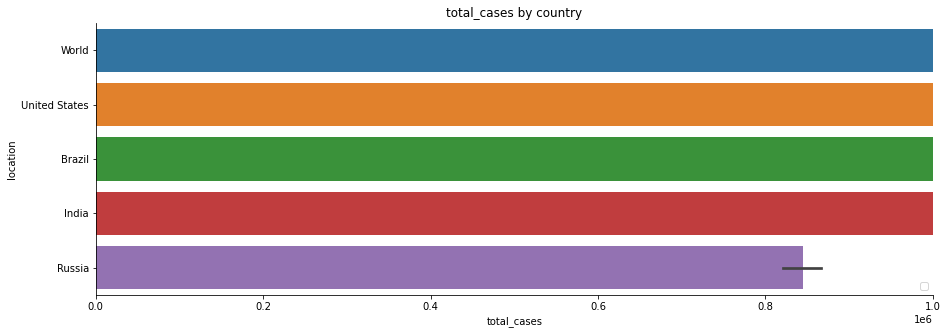

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


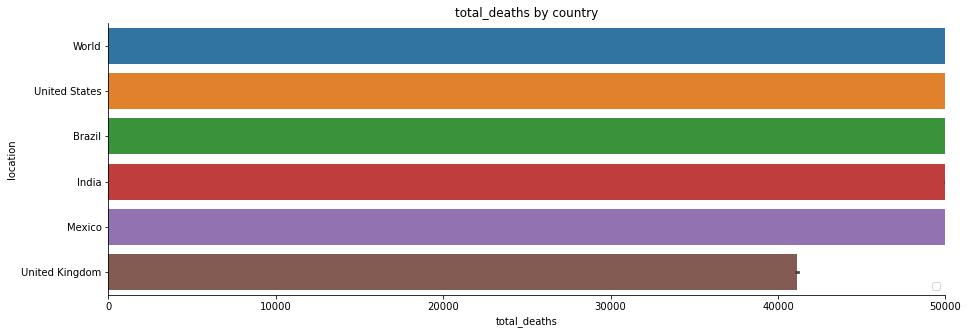

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


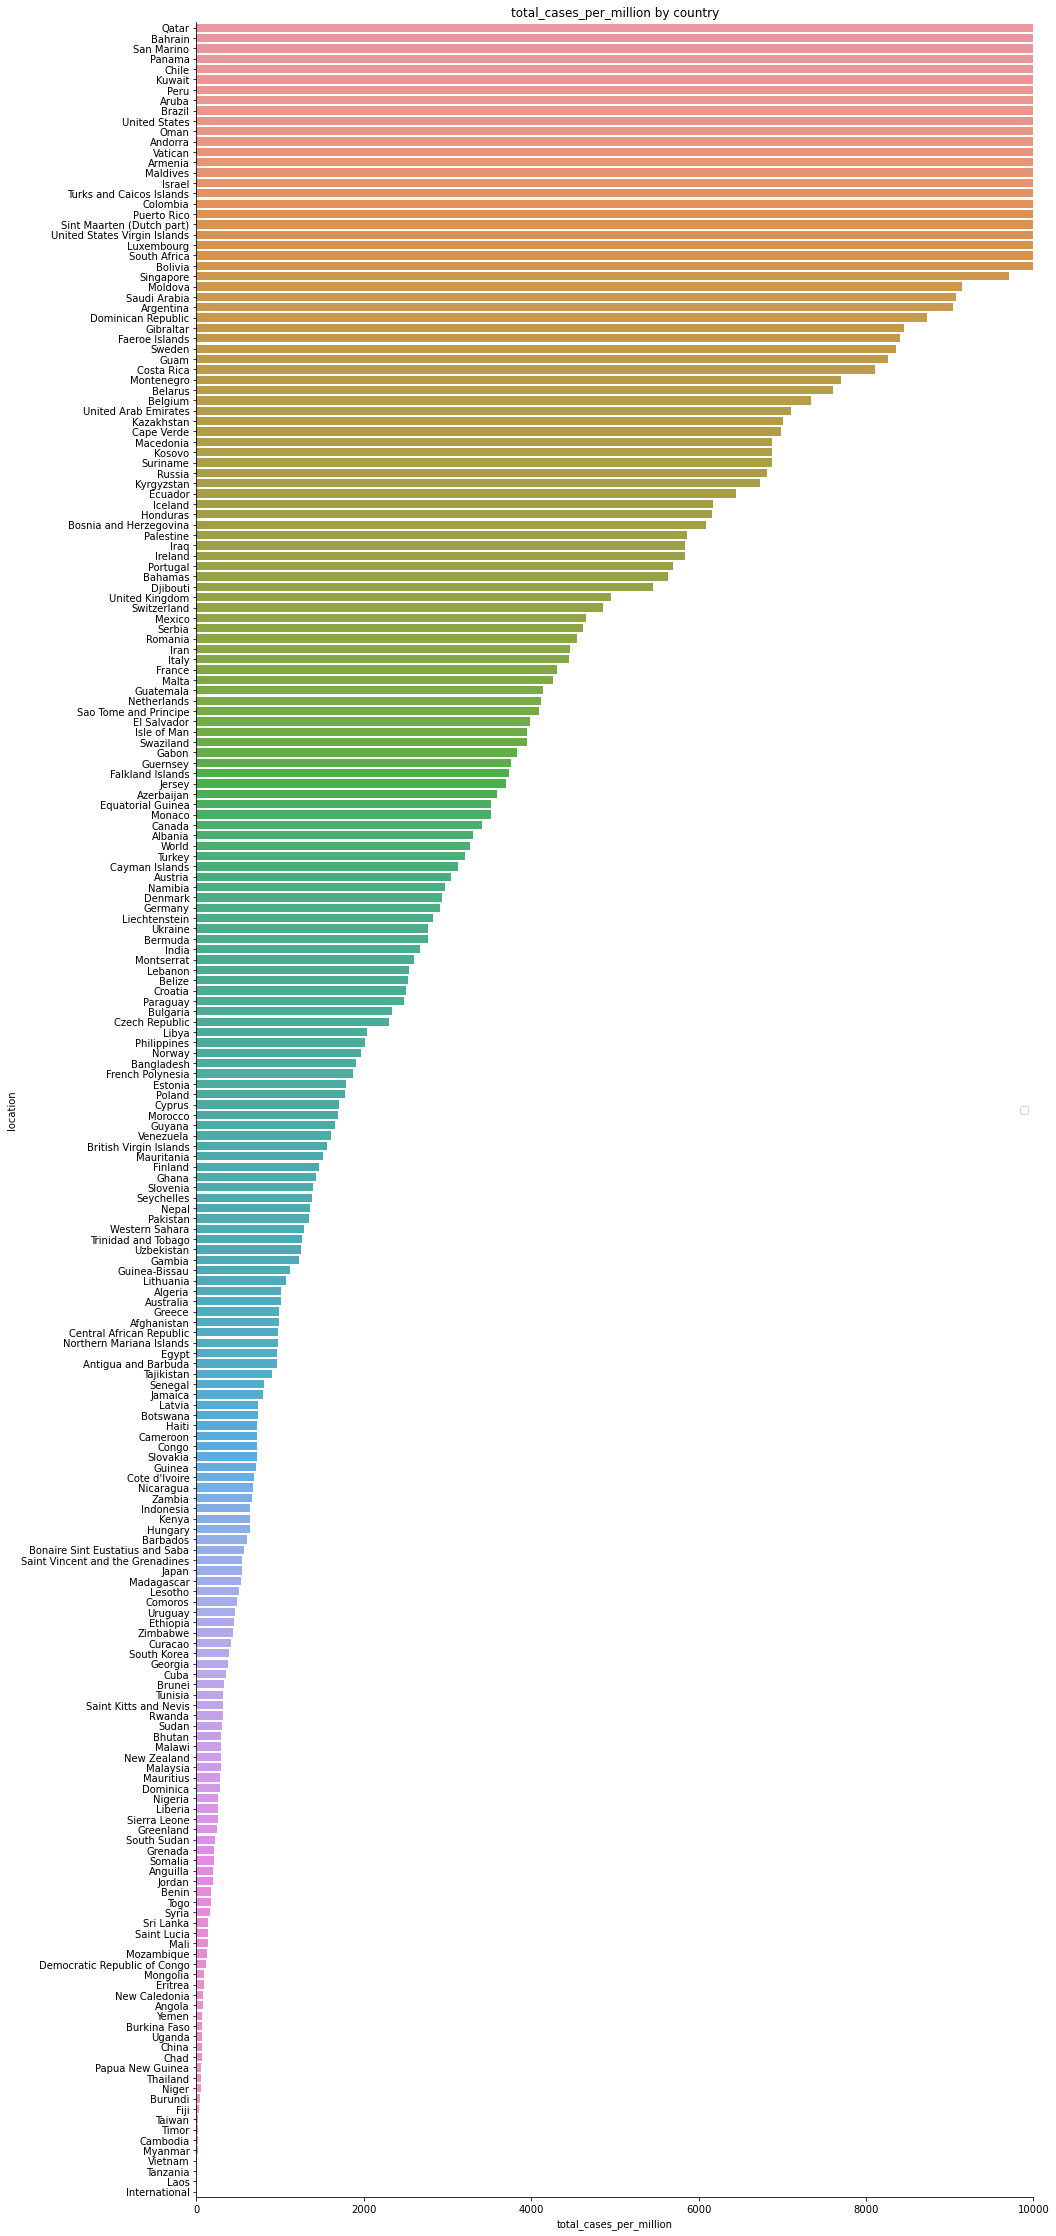

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


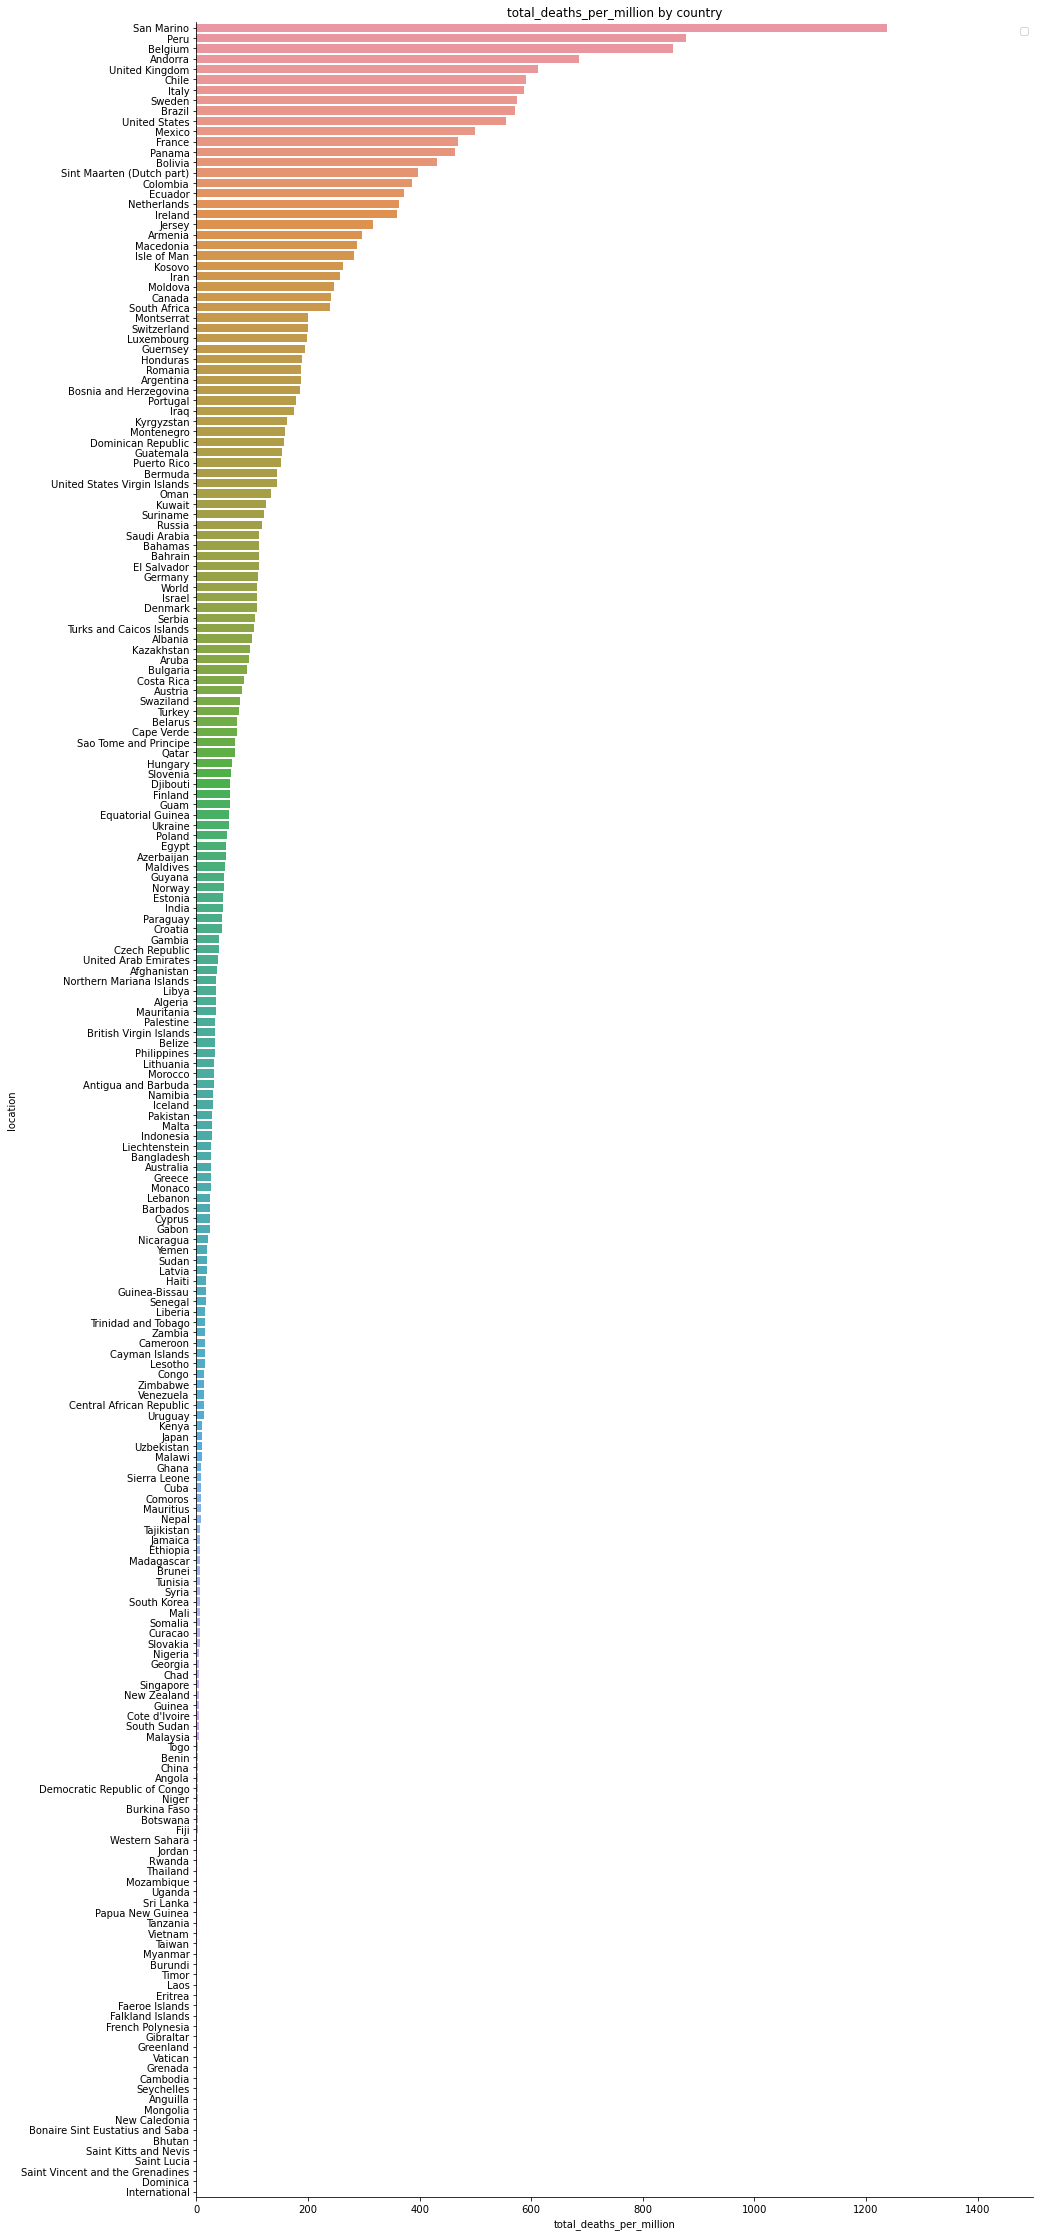

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

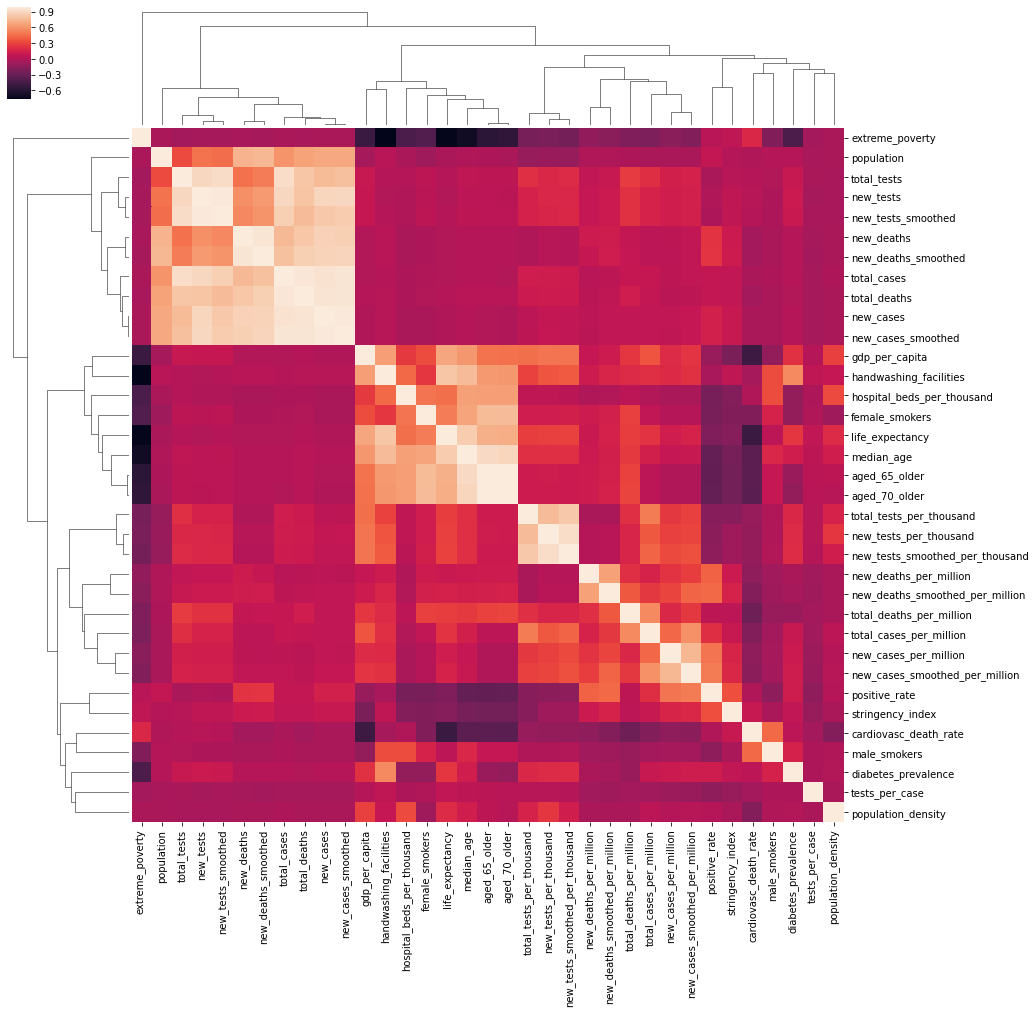

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9993221879289017 (+/- 0.0006191384573014795)
Coef :  [1.03713524e+00 9.13306155e-05 9.60820460e-05]
3 Last_days :  [[25030021 25275100 25509135]]
Today :  25509135
Prediction + :  538449
Tomorow :  26047584
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996603380859682 (+/- 6.436019990676043e-05)
Coef :  [0.05040511 0.46356711 0.49611675]
3 Last_days :  [[843141 846912 850902]]
Today :  850902
Prediction + :  8960
Tomorow :  859862
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9936009436675929 (+/- 0.002880464533897372)
Coef :  [-0.70246393  0.75223475  0.95239764]
3 Last_days :  [[272530 277943 281025]]
Today :  281025
Prediction + :  4464
Tomorow :  285489
                                     
--------- Total Death -----------------
                                     
R^2: 0.5660432823918439 (+/- 0.6050950900154426)
Coef :  [-0.75214844  0.7886448   0.96253829]
3 Last_days :  [[30602 30606 30635]]
Today :  30635
Prediction + :  24
Tomorow :  30659
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9251257891940972 (+/- 0.056260444292331194)
Coef :  [-0.32509289 -0.01905687  1.33841789]
3 Last_days :  [[89863 89895 89914]]
Today :  89914
Prediction + :  29
Tomorow :  89943
                                     
--------- Total Death -----------------
                                     
R^2: -173.08173520066734 (+/- 246.0480014048937)
Coef :  [-0.07702655  0.01244088  1.05648706]
3 Last_days :  [[4721 4722 4723]]
Today :  4723
Prediction + :  6
Tomorow :  4729
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9618026674918028 (+/- 0.05285399521318947)
Coef :  [-0.82747487  0.89999541  0.9267629 ]
3 Last_days :  [[266853 268218 269214]]
Today :  269214
Prediction + :  1247
Tomorow :  270461
                                     
--------- Total Death -----------------
                                     
R^2: 0.6858381977708081 (+/- 0.4164832866503853)
Coef :  [-0.82870347  0.89964262  0.92817304]
3 Last_days :  [[35473 35477 35483]]
Today :  35483
Prediction + :  24
Tomorow :  35507
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9273623155546794 (+/- 0.09216619906552516)
Coef :  [-0.53367729  0.40058713  1.13591204]
3 Last_days :  [[439286 439286 462858]]
Today :  462858
Prediction + :  4685
Tomorow :  467543
                                     
--------- Total Death -----------------
                                     
R^2: 0.10139311292254456 (+/- 1.0461546035043894)
Coef :  [-0.72484286  0.62525341  1.09858801]
3 Last_days :  [[29011 29011 29094]]
Today :  29094
Prediction + :  16
Tomorow :  29110
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.981092775761382 (+/- 0.02643312213555777)
Coef :  [0.07765185 0.46362624 0.4745791 ]
3 Last_days :  [[5961582 5997163 6031013]]
Today :  6031013
Prediction + :  88379
Tomorow :  6119392
                                     
--------- Total Death -----------------
                                     
R^2: 0.9802851770044181 (+/- 0.02663186825538772)
Coef :  [-0.53543735  0.72801132  0.80993438]
3 Last_days :  [[182779 183069 183598]]
Today :  183598
Prediction + :  840
Tomorow :  184438
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9295617548445652 (+/- 0.09872967308207009)
Coef :  [-0.73515256  0.85524546  0.8800798 ]
3 Last_days :  [[332752 334467 335873]]
Today :  335873
Prediction + :  1664
Tomorow :  337537
                                     
--------- Total Death -----------------
                                     
R^2: 0.35659268577083053 (+/- 0.8708735746219758)
Coef :  [-0.7720256   0.83186883  0.93955206]
3 Last_days :  [[41498 41499 41501]]
Today :  41501
Prediction + :  37
Tomorow :  41538
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9468666094896102 (+/- 0.07264532833932352)
Coef :  [-0.7976725   0.85773761  0.93958507]
3 Last_days :  [[241771 242381 243599]]
Today :  243599
Prediction + :  637
Tomorow :  244236
                                     
--------- Total Death -----------------
                                     
R^2: 0.3634093186257353 (+/- 0.8870901042588818)
Coef :  [-0.79162093  0.84122198  0.94971513]
3 Last_days :  [[9295 9298 9302]]
Today :  9302
Prediction + :  9
Tomorow :  9311
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: -18.515256348472594 (+/- 27.597411933711047)
Coef :  [0.22759661 0.39202887 0.39203552]
3 Last_days :  [[371816 373570 375212]]
Today :  375212
Prediction + :  4326
Tomorow :  379538
                                     
--------- Total Death -----------------
                                     
R^2: 0.9548333397037654 (+/- 0.06323232379777093)
Coef :  [0.01122468 0.50351041 0.49728088]
3 Last_days :  [[21359 21462 21571]]
Today :  21571
Prediction + :  254
Tomorow :  21825
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.998002561062973 (+/- 0.0025330444922338547)
Coef :  [-0.73657631  0.84823084  0.88571565]
3 Last_days :  [[267064 268546 270133]]
Today :  270133
Prediction + :  1224
Tomorow :  271357
                                     
--------- Total Death -----------------
                                     
R^2: 0.9989652614232986 (+/- 0.0009187804781216348)
Coef :  [-0.81030925  0.89290351  0.91459428]
3 Last_days :  [[6284 6326 6370]]
Today :  6370
Prediction + :  34
Tomorow :  6404
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.4479644144935217 (+/- 0.7770288814623928)
Coef :  [-0.14306394  0.49413095  0.66491847]
3 Last_days :  [[3846153 3862311 3908272]]
Today :  3908272
Prediction + :  54972
Tomorow :  3963244
                                     
--------- Total Death -----------------
                                     
R^2: 0.48521420701622714 (+/- 0.7253078108401427)
Coef :  [-0.1180947   0.51699225  0.61330636]
3 Last_days :  [[120462 120828 121381]]
Today :  121381
Prediction + :  1565
Tomorow :  122946
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(25509135, 850902, 26047584, 859862),
 (281025, 30635, 285489, 30659),
 (269214, 35483, 270461, 35507),
 (462858, 29094, 467543, 29110),
 (6031013, 183598, 6119392, 184438),
 (89914, 4723, 89943, 4729),
 (335873, 41501, 337537, 41538),
 (243599, 9302, 244236, 9311),
 (375212, 21571, 379538, 21825),
 (270133, 6370, 271357, 6404),
 (3908272, 121381, 3963244, 122946)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-01,France,285489.0,0.0,30659.0,0.0,0.0,0.0
0,2020-09-01,China,89943.0,0.0,4729.0,0.0,0.0,0.0
0,2020-09-01,Italy,270461.0,0.0,35507.0,0.0,0.0,0.0
0,2020-09-01,Spain,467543.0,0.0,29110.0,0.0,0.0,0.0
0,2020-09-01,United States,6119392.0,0.0,184438.0,0.0,0.0,0.0
0,2020-09-01,World,26047584.0,0.0,859862.0,0.0,0.0,0.0
0,2020-09-01,United Kingdom,337537.0,0.0,41538.0,0.0,0.0,0.0
0,2020-09-01,Germany,244236.0,0.0,9311.0,0.0,0.0,0.0
0,2020-09-01,Iran,379538.0,0.0,21825.0,0.0,0.0,0.0
0,2020-09-01,Turkey,271357.0,0.0,6404.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")